In [16]:
from scipy import *
import matplotlib.pyplot as plt
from matplotlib import cm
from random import randint, random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Diffusion-limited aggregation
#### Tan Beng Hau, Cavitation Lab

Diffusion-limited aggregation, or DLA, refers to a system mediated by diffusion (or the Laplace equation) in which particles moving in Brownian motion clump together to form intricate fractal structures.

These structures are observed in some natural systems, most notably in lightning, during which the air experiences dielectric breakdown. They are also observed in the formation of viscous fingers (aka the Saffman-Taylor instability), when one liquid invades into a second liquid of a higher viscosity. 

Recent studies in electron microscopes also show that electrodes form fractal dendrites due to build-up of salt precipitates (see for instance, White et al, ACS Nano, 2012, 6 (7), pp 6308–6317). The formation of these dendrites are presumably responsible for the gradual loss of quality in batteries after repeated use. To simulate this particular scenario, this notebook shows how dendrites aggregate from 'seeds' on a surface. 

In [201]:
from IPython.display import YouTubeVideo
YouTubeVideo("FWOst4VwwEU")

## Algorithm

The DLA algorithm is beautifully simple. First, we define a row of seeds along the bottom of the domain. 

At each time step $t_{\rm reps}$ we introduce a single Brownian particle at a random initial position, and get it to perform a two-dimensional random walk, such that it moves one step at the time in either $x$ or $y$ axis. When the particle's new position is adjacent to another particle or the seed row (this is the purpose of the `is_next_to_seed` function), it sticks and we call in the next particle. 

To speed up the simulation, we make a few simplifications. First, we define $L$ to be the length of the longest dendrite. If the Brownian particle moves too far away from the surface, i.e. $x > L+\epsilon$, we discard it and get a new one. Second, we can just outright restrict the Brownian particle to making just $n_{\rm max}=200$ steps and if it still hasn't stuck by then, we remove it and call the next particle in (again at some random position). 

In the original problem, the DLA is seeded from the centre, so the fractal is approximately symmetric. The Brownian particle is selected to start walking from any position in the lattice. 

### Modifying the algorithm for dendrite growth from a surface

In my view, the dendrite problem is a little bit more complicated. The motion of particles near the surface is very different from particles far away. First, the surface observes no-slip (or approximately so), meaning that a particle's velocity component parallel to the surface is zero. Second, the diffusion constant is reduced ('hindered') close to the surfaces as compared to the bulk. 

To account for this, I modify the standard algorithm so that each new Brownian particle starts with an $x$-coordinate (vertical in the graph) sampled from $x\in(L,N_x)$, where $N_x$ is the number of rows (as viewed in the figure below). To be frank, this isn't physically correct (essentially we assume no Brownian particles below $x<L$), but the net effect is to bias the Brownian particles to attach preferentially onto the longest dendrites and that is indeed observed in experiment. 

Note that the graph on the right tags the dendrite branches according to the time step at which they attach. 

In [86]:
def is_next_to_seed(x, y, M):
    is_next = False
    if (x>0) and (x < M.shape[0]-1) and (y>0) and (y < M.shape[1]-1):
        if (M[x-1,y]==1) or (M[x+1,y]==1) or (M[x,y+1]==1) or (M[x,y-1]==1): 
            is_next = True
            
    return is_next

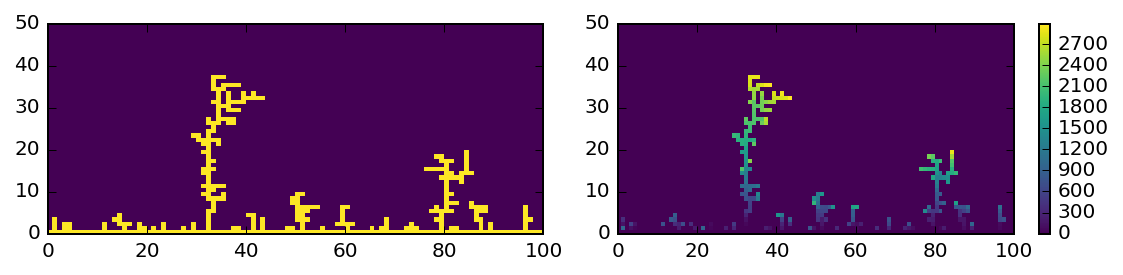

In [202]:
N = 50
M = zeros((N,2*N))
M_time = zeros_like(M)

# Initialise the bottom row as a seed.
M[0,:] = 1

dend_size = 0

for j_reps in range(3000):

    # Pick a random point 
    #x_rand = randint(1, max(cluster_size+20, M.shape[0]))
    #y_rand = randint(0, max(cluster_size+20, M.shape[1]))
    x_rand = randint(dend_size+1, max(dend_size+20, M.shape[0]))
    y_rand = randint(dend_size, max(dend_size+20, M.shape[1]))

    x_new = x_rand
    y_new = y_rand
    for n_reps in range(200):

        if is_next_to_seed(x_new, y_new, M) == True:
            M[x_new, y_new] = 1
            M_time[x_new, y_new] = j_reps
            break
            
        if x_new > max(dend_size+20, M.shape[0]):
            break

        else:
            # Pick an orientation - take one step up/down or
            # one step left/right
            orientation = 2*randint(0,1)-1 
            if orientation == 1:
                x_new += 2*randint(0,1)-1
            else:
                y_new += 2*randint(0,1)-1
                
    # Update the dendrite size
    # ... basically the largest nonzero row number
    dend_size = max(transpose(array(nonzero(M)))[:,0])
        
plt.figure(figsize=(8,2))
plt.subplot(121)
plt.pcolor(M, cmap = cm.viridis)
plt.subplot(122)
plt.pcolor(M_time, cmap = cm.viridis)
plt.colorbar()
plt.tight_layout()

## Without the bias

In this part we perform the standard DLA algorithm, i.e. we do not bias the particle to attach preferentially on the longest dendrites. We see instead that the coverage is now much more uniform.

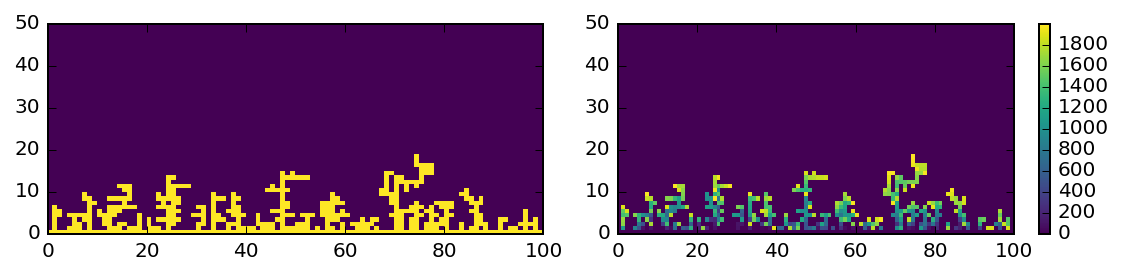

In [205]:
N = 50
M = zeros((N,2*N))
M_time = zeros_like(M)

# Initialise the bottom row as a seed.
M[0,:] = 1

dend_size = 0

for j_reps in range(2000):

    # Pick a random point 
    x_rand = randint(1, max(cluster_size+20, M.shape[0]))
    y_rand = randint(0, max(cluster_size+20, M.shape[1]))

    x_new = x_rand
    y_new = y_rand
    for n_reps in range(200):

        if is_next_to_seed(x_new, y_new, M) == True:
            M[x_new, y_new] = 1
            M_time[x_new, y_new] = j_reps
            break
            
        if x_new > max(dend_size+20, M.shape[0]):
            break

        else:
            # Pick an orientation - take one step up/down or
            # one step left/right
            orientation = 2*randint(0,1)-1 
            if orientation == 1:
                x_new += 2*randint(0,1)-1
            else:
                y_new += 2*randint(0,1)-1
                
    # Update the dendrite size
    # ... basically the largest nonzero row number
    dend_size = max(transpose(array(nonzero(M)))[:,0])
        
plt.figure(figsize=(8,2))
plt.subplot(121)
plt.pcolor(M, cmap = cm.viridis)
plt.subplot(122)
plt.pcolor(M_time, cmap = cm.viridis)
plt.colorbar()
plt.tight_layout()

## Symmetric DLA

Finally, we show the symmetric case, similar to what is observed with viscous fingers. Instead of tracking the length of the longest dendrite, we track the cluster radius $r = \sqrt{A/\pi}$, where $A = \sum_{i,j} M$, and only consider Brownian particles within a region $r+\epsilon$. 

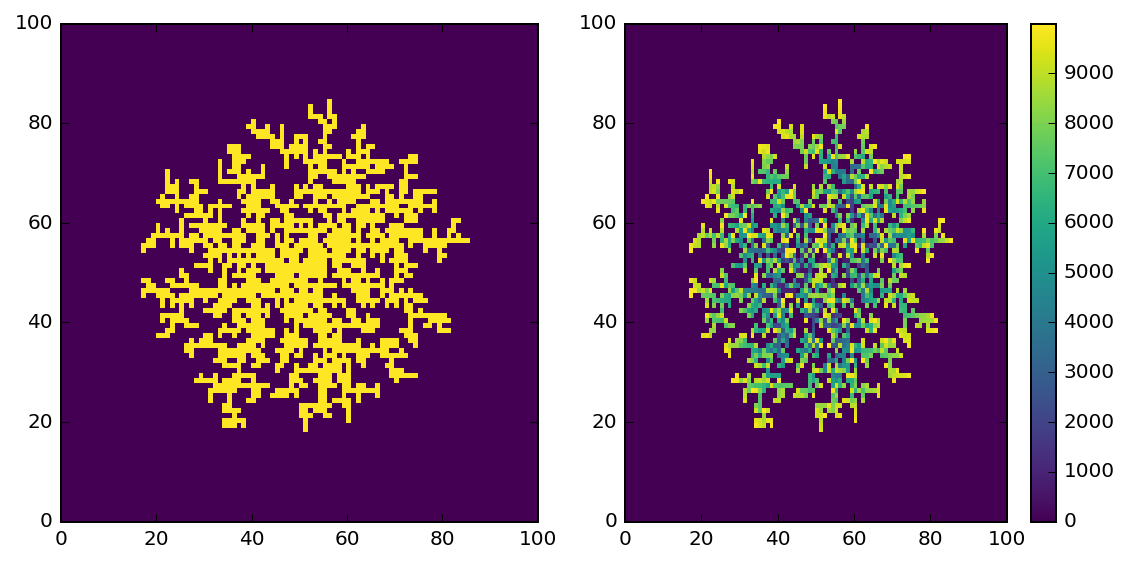

In [217]:
N = 100
M = zeros((N,N))
M_time = zeros_like(M)

# Initialise centre point as a seed.
M[int(N/2),int(N/2)] = 1

cluster_size = 0

for j_reps in range(10000):

    # Pick a random point 
    x_rand = randint(0, M.shape[0])
    y_rand = randint(0, M.shape[1])

    x_new = x_rand
    y_new = y_rand

    while sqrt((x_new-N/2.)**2 + (y_new-N/2.)**2) < cluster_size+20:

        if is_next_to_seed(x_new, y_new, M) == True:
            M[x_new, y_new] = 1
            M_time[x_new, y_new] = j_reps
            break
            
        else:
            # Pick an orientation - take one step up/down or
            # one step left/right
            orientation = 2*randint(0,1)-1 
            if orientation == 1:
                x_new += 2*randint(0,1)-1
            else:
                y_new += 2*randint(0,1)-1
                
    # Update the cluster size
    # ... basically the largest nonzero row number
    cluster_size = sqrt(sum(sum(M))/pi)
        
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.pcolor(M, cmap = cm.viridis)
plt.subplot(122)
plt.pcolor(M_time, cmap = cm.viridis)
plt.colorbar()
plt.tight_layout()